# 🏏 Cricket Player Detection & Tracking Pipeline
**Objective:** Detect players, assign unique IDs, and map their positions to a top-down view of the cricket pitch.

**Workflow:**
1.  **Setup:** Install dependencies and mount Google Drive.
2.  **Data Prep:** Extract frames and auto-label using YOLO-World (if needed).
3.  **Training:** Fine-tune YOLOv11 on the custom dataset.
4.  **Calibration:** Compute Homography matrix for Camera -> Top-View mapping.
5.  **Inference:** Run detection, tracking, and projection on the video.

## 🛠️ Setup & Environment
**Objective:** Prepare the workspace by installing necessary computer vision libraries and mounting Google Drive for data access.
* **Libraries:** `ultralytics` (YOLO), `opencv`, and `supervision`.
* **Storage:** Connect to Google Drive to retrieve source videos and save processed results.

In [8]:
# Install Ultralytics for YOLO
!pip install ultralytics -q

import os
import cv2
import numpy as np
import glob
import shutil
from ultralytics import YOLO, YOLOWorld
from sklearn.model_selection import train_test_split
from google.colab import drive
from collections import defaultdict

# Mount Drive
drive.mount('/content/drive')

# Configuration
BASE_DIR = "/content/drive/MyDrive/Khel_AI_Assignment"
VIDEO_NAME = "2025-08-23 20-34-30.mp4"
MAP_NAME = "Ground Image.png"
OUTPUT_NAME = "Final_Submission.mp4"

# Validate Paths
if not os.path.exists(BASE_DIR):
    print(f"❌ Error: Base directory not found: {BASE_DIR}")
else:
    print(f"✅ Setup Complete. Working directory: {BASE_DIR}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Setup Complete. Working directory: /content/drive/MyDrive/Khel_AI_Assignment


## 📋 1. Data Preparation & Cleaning
**Objective:** Generate a high-quality training dataset for cricket player detection.
**Process:**
* **Extraction:** Sampling frames from the source video match.
* **Auto-Labeling:** Using **YOLO-World** to generate zero-shot annotations for the "person" class.
* **Data Cleaning:** Implementing logic to filter out noise, tiny detections, and flat shadows to ensure the model focuses on actual players.
* **Formatting:** Organizing images and labels into YOLO-compliant folder structures.

In [ ]:
# Frame extraction & Auto Labeling
frames_dir = "dataset_frames_robust"

# 1. Clean/Create the folder
if os.path.exists(frames_dir):
    existing = len(os.listdir(frames_dir))
    if existing > 100:
        print(f"⚠️ Found {existing} images already in '{frames_dir}'. Skipping extraction to save time.")
        print("   (If you want to re-extract, delete the folder and run this block again.)")
        DO_EXTRACTION = False
    else:
        shutil.rmtree(frames_dir)
        os.makedirs(frames_dir)
        DO_EXTRACTION = True
else:
    os.makedirs(frames_dir)
    DO_EXTRACTION = True

# 2. Extract Frames
if DO_EXTRACTION:
    print("📸 Starting extraction...")
    video_files = glob.glob(os.path.join(base_path, "*.mp4"))

    total_extracted = 0
    FRAMES_PER_VIDEO = 150 # Taking 150 frames per video

    for i, video_path in enumerate(video_files):
        print(f"   Processing Video {i+1}/{len(video_files)}: {os.path.basename(video_path)}")

        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        if total_frames > 0:
            # Pick evenly spaced frames
            indices = np.linspace(0, total_frames-1, min(FRAMES_PER_VIDEO, total_frames), dtype=int)

            saved_count = 0
            frame_idx = 0
            while True:
                ret, frame = cap.read()
                if not ret: break

                if frame_idx in indices:
                    # Save as vid0_img1.jpg, vid1_img1.jpg, etc.
                    filename = f"vid{i}_img_{saved_count}.jpg"
                    cv2.imwrite(os.path.join(frames_dir, filename), frame)
                    saved_count += 1
                    total_extracted += 1
                frame_idx += 1
        cap.release()

    print(f"✅ Extraction Complete. Total images ready: {total_extracted}")

⚠️ Found 450 images already in 'dataset_frames_robust'. Skipping extraction to save time.
   (If you want to re-extract, delete the folder and run this block again.)


In [ ]:
# Auto-Labeling
print("🏷️ Starting Auto-Labeling...")

# 1. Load the Model

model_world = YOLOWorld('yolov8l-worldv2.pt')
model_world.set_classes(["person"])

# 2. Run Prediction
# conf=0.10 ensures we detect blurry players too.
results = model_world.predict(frames_dir, save_txt=True, save_conf=True, conf=0.10, verbose=False)

# 3. Verify Labels Exist
runs_dir = "runs/detect"
if os.path.exists(runs_dir):
    # Find the newest folder created by the prediction
    all_runs = [os.path.join(runs_dir, d) for d in os.listdir(runs_dir) if os.path.isdir(os.path.join(runs_dir, d))]
    latest_run = max(all_runs, key=os.path.getmtime)
    label_source = os.path.join(latest_run, "labels")

    if os.path.exists(label_source):
        num_labels = len(os.listdir(label_source))
        print(f"✅ Auto-Labeling Complete.")
        print(f"   Labels saved in: {label_source}")
        print(f"   Files generated: {num_labels} (Should be close to 450)")

        if num_labels == 0:
            print("❌ ERROR: Created 0 label files! The model detected nothing.")
            print("   Try running this block again with conf=0.01")
    else:
        print(f"❌ ERROR: 'labels' folder not found in {latest_run}")
else:
    print("❌ ERROR: 'runs/detect' folder not generated.")

🏷️ Starting Auto-Labeling...
Results saved to /content/runs/detect/predict2
450 labels saved to /content/runs/detect/predict2/labels
✅ Auto-Labeling Complete.
   Labels saved in: runs/detect/predict2/labels
   Files generated: 450 (Should be close to 450)


In [ ]:
# Data Cleaning and formatting
print("🧹 Cleaning data and creating splits...")

# 1. Setup Target Folders
dataset_root = "yolo11_finetune_data"
# Reset folder to ensure no old data remains
if os.path.exists(dataset_root): shutil.rmtree(dataset_root)

for split in ['train', 'val']:
    os.makedirs(f"{dataset_root}/images/{split}", exist_ok=True)
    os.makedirs(f"{dataset_root}/labels/{split}", exist_ok=True)

# 2. Get File Lists
# We use the label_source from the previous block (runs/detect/predict2/labels)
valid_files = [f for f in os.listdir(frames_dir) if f.endswith('.jpg')]
train_files, val_files = train_test_split(valid_files, test_size=0.15, random_state=42)

def process_and_clean(files, split_name):
    count_saved = 0
    for f in files:
        txt_name = f.replace('.jpg', '.txt')
        src_txt_path = os.path.join(label_source, txt_name)

        # Only process if we actually have a label file
        if os.path.exists(src_txt_path):
            with open(src_txt_path, 'r') as file:
                lines = file.readlines()

            clean_lines = []
            for line in lines:
                parts = line.strip().split()
                if len(parts) >= 5:
                    w_box = float(parts[3])
                    h_box = float(parts[4])

                    # --- FILTERS ---
                    # 1. Remove tiny noise (width < 0.5% or height < 1% of screen)
                    # 2. Remove flat objects (Shadows/Pitch lines). Aspect Ratio (h/w) must be > 0.5
                    if w_box > 0.005 and h_box > 0.01:
                        if (h_box / w_box) > 0.5:
                            # Save as class '0' (player)
                            clean_lines.append(f"0 {parts[1]} {parts[2]} {parts[3]} {parts[4]}\n")

            # If we have valid boxes left after filtering, save the image and label
            if clean_lines:
                # Copy Image
                shutil.copy(os.path.join(frames_dir, f), f"{dataset_root}/images/{split_name}/{f}")
                # Save Label
                with open(f"{dataset_root}/labels/{split_name}/{txt_name}", 'w') as file:
                    file.writelines(clean_lines)
                count_saved += 1
    return count_saved

# 3. Run the Processing
train_count = process_and_clean(train_files, 'train')
val_count = process_and_clean(val_files, 'val')

# 4. Create YAML Configuration
yaml_content = f"""
path: {os.path.abspath(dataset_root)}
train: images/train
val: images/val
names:
  0: player
"""
with open(f"{dataset_root}/data.yaml", "w") as f:
    f.write(yaml_content)

print(f"✅ Data Preparation Complete.")
print(f"   Training Images: {train_count}")
print(f"   Validation Images: {val_count}")

if train_count == 0:
    print("❌ CRITICAL ERROR: 0 images saved. The cleaning filter removed ALL labels.")
    print("   Please tell me if you see this error.")

🧹 Cleaning data and creating splits...
✅ Data Preparation Complete.
   Training Images: 382
   Validation Images: 68


## 🧠 2. YOLOv11 Model Training
**Objective:** Fine-tune the YOLOv11 Nano architecture to achieve high precision in player detection.
**Configuration:**
* **Base Model:** `yolo11n.pt` for an optimal balance of speed and accuracy.
* **Augmentation:** Applying Mosaic and Scale augmentations to handle varying camera zooms and player occlusions.
* **Optimization:** Using early stopping (`patience=15`) to prevent overfitting and capture the best weights.

In [ ]:
# Training
print("🚀 Starting YOLOv11 Training...")

# 1. Load the Model
# We use 'yolo11n.pt' (Nano) for speed.
# If you want slightly better accuracy (but slower), change 'n' to 's' below.
model = YOLO('yolo11n.pt')

# 2. Run Training
# We use 'patience=15' to stop early if it stops improving (saves time).
model.train(
    data=f"{dataset_root}/data.yaml",
    epochs=60,               # Max epochs
    imgsz=640,
    batch=16,                # Batch size
    project=project_path,    # Save folder
    name=model_name,         # Run name

    # --- AUGMENTATION (Crucial for small datasets) ---
    augment=True,
    mosaic=1.0,              # Stitches images together (learns context)
    scale=0.5,               # Simulates zoom in/out
    fliplr=0.5,              # Flips left/right
    hsv_h=0.015,             # Light/Color variations

    patience=15,             # Stop if no improvement for 15 epochs
    verbose=True
)

print(f"✅ Training Complete.")
print(f"   Best model saved at: {project_path}/{model_name}/weights/best.pt")

🚀 Starting YOLOv11 Training...
Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo11_finetune_data/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=optimized_nano_multi_video2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=T

## 📐 3. Homography Calibration
**Objective:** Calculate the transformation matrix required to project 2D video coordinates onto a top-down ground map.
**Method:**
* Identify corresponding points between the video's perspective pitch and the ground reference image.
* Compute the **Homography Matrix** using `cv2.findHomography`.
* Verify the alignment visually using a projected coordinate check.

⚠️ Specific path '/content/drive/MyDrive/Khel_AI_Assignment/optimized_nano_multi_video2/weights/best.pt' not found.
🔍 Searching for the latest 'best.pt' in your folder...
📍 Calibrating using video: 2025-08-23 20-34-30.mp4
🤖 Using Model: best.pt
✅ Homography Matrix Calculated.


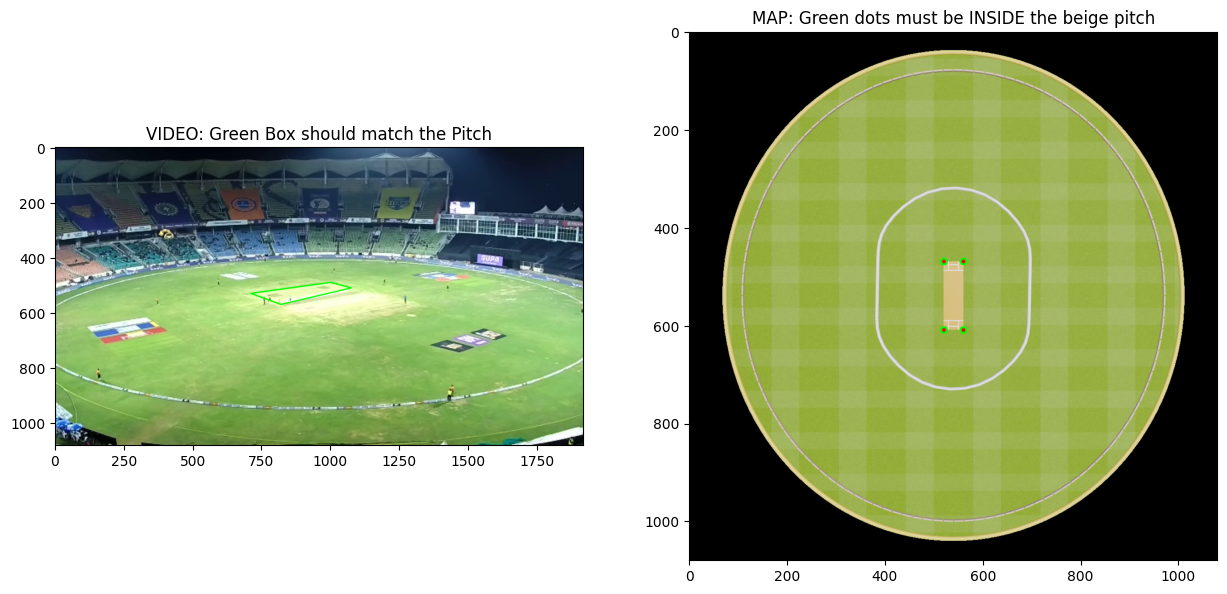

In [10]:
# Homography Calibration
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

# paths
project_path = "/content/drive/MyDrive/Khel_AI_Assignment"
ground_path = os.path.join(project_path, "Ground Image.png")
video_path = os.path.join(project_path, "2025-08-23 20-34-30.mp4")
target_model = os.path.join(project_path, "optimized_nano_multi_video2", "weights", "best.pt")

if os.path.exists(target_model):
    model_path = target_model
else:
    print(f"⚠️ Specific path '{target_model}' not found.")
    print("🔍 Searching for the latest 'best.pt' in your folder...")
    found_models = glob.glob(os.path.join(project_path, "**", "best.pt"), recursive=True)
    if found_models:
        model_path = max(found_models, key=os.path.getmtime)
    else:
        model_path = "yolo11n.pt" # Fallback

print(f"📍 Calibrating using video: {os.path.basename(video_path)}")
print(f"🤖 Using Model: {os.path.basename(model_path)}")

# 2. Load Images
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
cap.release()
ground_img = cv2.imread(ground_path)

if frame is None or ground_img is None:
    raise FileNotFoundError("❌ Error: Could not load Video or Ground Image. Check paths!")


# Coordinates set up

# =========================================================

# 1. VIDEO POINTS (Source)
src_pts = np.float32([
    [1000, 490],  # Top-Left
    [1075, 510],  # Top-Right
    [820, 570],   # Bottom-Right
    [710, 530]    # Bottom-Left
])

# 2. MAP POINTS (Destination)
dst_pts = np.float32([
    [520, 470],   # Top-Left
    [560, 470],   # Top-Right
    [560, 610],   # Bottom-Right
    [520, 610]    # Bottom-Left
])

# =========================================================

# 3. Calculate Homography
H_matrix, status = cv2.findHomography(src_pts, dst_pts)
print("✅ Homography Matrix Calculated.")

# 4. Verify Alignment (The "Sanity Check")
pts_reshaped = src_pts.reshape(-1, 1, 2)
projected_pts = cv2.perspectiveTransform(pts_reshaped, H_matrix)

verify_img = ground_img.copy()
for i, p in enumerate(projected_pts):
    x, y = int(p[0][0]), int(p[0][1])
    # Green = Code's prediction
    cv2.circle(verify_img, (x, y), 8, (0, 255, 0), -1)
    # Red = Target location
    cv2.circle(verify_img, (int(dst_pts[i][0]), int(dst_pts[i][1])), 4, (0, 0, 255), -1)

# Show Plot
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
ax[0].set_title("VIDEO: Green Box should match the Pitch")
# Draw box on video frame for visual check
cv2.polylines(frame, [src_pts.astype(np.int32)], True, (0, 255, 0), 3)
ax[0].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

ax[1].imshow(cv2.cvtColor(verify_img, cv2.COLOR_BGR2RGB))
ax[1].set_title("MAP: Green dots must be INSIDE the beige pitch")
plt.show()



## 🎬 4. Final Inference & Bird's-Eye Projection
**Objective:** Generate the final output video featuring synchronized player tracking and top-view visualization.
**Pipeline:**
1.  **Detection & Tracking:** Run the custom-trained model with **ByteTrack** for persistent ID assignment.
2.  **Filtering:** Use a field boundary polygon to exclude spectators.
3.  **Projection:** Map player foot-positions to the ground map in real-time.
4.  **Visualization:** Render side-by-side video with bounding boxes, unique IDs, and motion trails.

In [11]:

from collections import defaultdict
import cv2
import numpy as np
import os
import glob
from ultralytics import YOLO

# =========================================================
# 1. CONFIGURATION
# =========================================================
MAIN_DIR = "/content/drive/MyDrive/Khel_AI_Assignment"
OUTPUT_NAME = "Final_Submission_Custom_Model.mp4"

# =========================================================
# 2. LOCATE YOUR CUSTOM TRAINED MODEL
# =========================================================
print("🔍 Searching for your custom 'best.pt' in Drive...")


found_models = glob.glob(os.path.join(MAIN_DIR, "**", "weights", "best.pt"), recursive=True)

if found_models:
    model_path = max(found_models, key=os.path.getmtime)
    print(f"✅ Found Custom Model: {model_path}")
else:
    print("⚠️ Custom model not found. Checking for backup...")
    # Fallback
    model_path = "yolo11n.pt"
    print(f"⚠️ Falling back to generic: {model_path}")

# Paths
video_path = os.path.join(MAIN_DIR, "2025-08-23 20-34-30.mp4")
ground_path = os.path.join(MAIN_DIR, "Ground Image.png")
output_path = os.path.join(MAIN_DIR, OUTPUT_NAME)

# =========================================================
# 3. GEOMETRY SETUP
# =========================================================

# 1. SOURCE (Video)
src_pts = np.float32([
    [1000, 490],  # Top-Left
    [1075, 510],  # Top-Right
    [820, 570],   # Bottom-Right
    [710, 530]    # Bottom-Left
])

# 2. DESTINATION (Map)
dst_pts = np.float32([
    [520, 470],   # Top-Left
    [560, 470],   # Top-Right
    [560, 610],   # Bottom-Right
    [520, 610]    # Bottom-Left
])

H_matrix, _ = cv2.findHomography(src_pts, dst_pts)

# Field Boundary (Polygon to ignore spectators outside)
field_polygon = np.array([
    [0, 1080], [0, 600], [300, 450], [960, 330],
    [1620, 450], [1920, 600], [1920, 1080]
], np.int32)

# =========================================================
# 4. PROCESSING LOOP
# =========================================================
# Load custom model
model = YOLO(model_path)

cap = cv2.VideoCapture(video_path)
ground_img = cv2.imread(ground_path)

# Video Props
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Resize Map to fit side-by-side
target_h = h
scale_ratio = target_h / ground_img.shape[0]
new_map_w = int(ground_img.shape[1] * scale_ratio)
resized_map_template = cv2.resize(ground_img, (new_map_w, target_h))

out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (w + new_map_w, h))

# Tracking variables
active_tracks = {}
track_history = defaultdict(list)
MAX_FRAMES = 900  # Process first 900 frames for submission

print(f"🚀 Processing Video: {OUTPUT_NAME}")
print(f"   Using Model: {os.path.basename(model_path)}")

frame_count = 0
while cap.isOpened():
    success, frame = cap.read()
    if not success: break
    if MAX_FRAMES and frame_count >= MAX_FRAMES: break
    frame_count += 1
    if frame_count % 50 == 0: print(f"   Frame {frame_count}...")

    # Inference using CUSTOM MODEL
    # We use conf=0.15 because custom models are usually more confident than generic ones
    results = model.track(frame, persist=True, conf=0.15, imgsz=1280, tracker="bytetrack.yaml", verbose=False)

    annotated_frame = frame.copy()
    current_map = resized_map_template.copy()

    # Draw Pitch Box (Green) for verification
    cv2.polylines(annotated_frame, [src_pts.astype(np.int32)], True, (0, 255, 0), 2)

    # Tracking Logic
    current_frame_ids = []
    if results[0].boxes.id is not None:
        boxes = results[0].boxes.xywh.cpu()
        track_ids = results[0].boxes.id.int().cpu().tolist()
        classes = results[0].boxes.cls.int().cpu().tolist()

        for box, track_id, cls in zip(boxes, track_ids, classes):
            # Since trained only 1 class (Player = 0), filter for 0
            if cls != 0: continue

            x, y, w_box, h_box = box
            feet_x, feet_y = float(x), float(y + h_box/2)

            # Check if inside field polygon
            if cv2.pointPolygonTest(field_polygon, (feet_x, feet_y), False) >= 0:
                active_tracks[track_id] = {
                    'box': [float(x), float(y), float(w_box), float(h_box)],
                    'missing': 0
                }
                current_frame_ids.append(track_id)

    # Draw Tracks & Map
    ids_to_remove = []
    for track_id, info in active_tracks.items():
        if track_id not in current_frame_ids:
            info['missing'] += 1
        if info['missing'] > 30:
            ids_to_remove.append(track_id)
            continue

        x, y, w_box, h_box = info['box']
        feet_x, feet_y = x, y + h_box/2

        # 1. Video Box
        x1, y1 = int(x - w_box/2), int(y - h_box/2)
        x2, y2 = int(x + w_box/2), int(y + h_box/2)
        cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(annotated_frame, f"{track_id}", (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)

        # 2. Map Projection
        vec = np.array([[[feet_x, feet_y]]], dtype=np.float32)
        transformed = cv2.perspectiveTransform(vec, H_matrix)[0][0]
        tx = int(transformed[0] * scale_ratio)
        ty = int(transformed[1] * scale_ratio)

        # Draw on map
        if 0 <= tx < new_map_w and 0 <= ty < target_h:
            cv2.circle(current_map, (tx, ty), 6, (0, 0, 255), -1) # Red Dot
            cv2.putText(current_map, f"{track_id}", (tx+8, ty), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

        # Trail
        track_history[track_id].append((feet_x, feet_y))
        if len(track_history[track_id]) > 30: track_history[track_id].pop(0)
        pts = np.hstack(track_history[track_id]).astype(np.int32).reshape((-1, 1, 2))
        cv2.polylines(annotated_frame, [pts], False, (200, 200, 200), 2)

    for tid in ids_to_remove:
        del active_tracks[tid]

    # Save
    final_canvas = np.hstack((annotated_frame, current_map))
    out.write(final_canvas)

cap.release()
out.release()
print(f"✅ DONE! Video saved as: {output_path}")

🔍 Searching for your custom 'best.pt' in Drive...
✅ Found Custom Model: /content/drive/MyDrive/Khel_AI_Assignment/Backup_2025-12-23_03-08/optimized_nano_multi_video2/weights/best.pt
🚀 Processing Video: Final_Submission_Custom_Model.mp4
   Using Model: best.pt
   Frame 50...
   Frame 100...
   Frame 150...
   Frame 200...
   Frame 250...
   Frame 300...
   Frame 350...
   Frame 400...
   Frame 450...
   Frame 500...
   Frame 550...
   Frame 600...
   Frame 650...
   Frame 700...
   Frame 750...
   Frame 800...
   Frame 850...
   Frame 900...
✅ DONE! Video saved as: /content/drive/MyDrive/Khel_AI_Assignment/Final_Submission_Custom_Model.mp4
